In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import glob
import cv2
import os

from sklearn.cluster import KMeans, spectral_clustering
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from scipy.signal import find_peaks

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

import tensorflow as tf

In [2]:
!ls data

annotations.csv frames          info.csv        video


In [3]:
info = pd.read_csv('data/info.csv', header=None)

In [4]:
# 20 annotation scores per frame for each video 
# each row is a new set of annotation scores of each video, with 20 rows per video
# scores are from 1-5
# 2 second long shot-level importance scores
annotations = pd.read_csv('data/annotations.csv', header=None)

In [5]:
# 20 videos
# 5 videos per category

# VT: Changing Vehicle Tire
# VU: Getting Vehicle Unstuck
# GA: Grooming an Animal
# MS: Making Sandwich
# PK: Parkour
# PR: Parade
# FM: Flash Mob Gathering
# BK: Bee Keeping
# BT: Attempting Bike Tricks
# DS: Dog Show

info = pd.read_csv('data/info.csv')

In [6]:
annotations.rename(columns={0: 'filename', 1: 'category', 2: 'annotations'}, inplace=True)

In [7]:
annotations.head()

,filename,category,annotations
0,AwmHb44_ouw,VT,"4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,..."
1,AwmHb44_ouw,VT,"2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,..."
2,AwmHb44_ouw,VT,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,..."
3,AwmHb44_ouw,VT,"4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,..."
4,AwmHb44_ouw,VT,"2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,..."


In [8]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
filename       1000 non-null object
category       1000 non-null object
annotations    1000 non-null object
dtypes: object(3)
memory usage: 23.6+ KB


In [9]:
info.head()

,category,video_id,title,url,length
0,VT,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54
1,VT,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07
2,VT,J0nA4VgnoCo,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44
3,VT,gzDbaEs1Rlg,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48
4,VT,XzYM3PfTM4w,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51


In [10]:
annotations['annotations'] = annotations['annotations'].apply(lambda a: a.split(','))

In [11]:
avg_annotations = []
for fname in annotations.filename.unique():
    values = annotations[annotations['filename'] == fname]['annotations'].values
    float_conversion = np.array(list(values)).astype('float64') 
    avg = np.mean(float_conversion, axis=0)
    avg_annotations.append(avg)

In [12]:
average_scores = pd.DataFrame({'filename': annotations.filename.unique(), 'average_score': avg_annotations})

In [13]:
average_scores.sort_values(by='filename')

,filename,average_score
49,-esJrBWj2d8,"[1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.9..."
12,0tmA_C6XwfM,"[1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.1..."
18,37rzWOQsNIw,"[3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.2..."
13,3eYKfiOEJNs,"[1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, ..."
29,4wU_LUjG5Ic,"[1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.9..."
25,91IHQYk1IQM,"[1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ..."
1,98MoyGZKHXc,"[1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7..."
0,AwmHb44_ouw,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
11,Bhxk-O1Y7Ho,"[2.95, 2.95, 2.95, 2.95, 2.95, 2.95, 2.95, 2.9..."
45,E11zDS9XGzg,"[1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.6..."


In [14]:
info.columns

Index(['category', 'video_id', 'title', 'url', 'length'], dtype='object')

In [15]:
info[info['video_id'] == '-esJrBWj2d8']

,category,video_id,title,url,length
49,DS,-esJrBWj2d8,Will A Cat Eat Dog Food?,https://www.youtube.com/watch?v=-esJrBWj2d8,3:50


In [16]:
# for video in glob.glob('data/video/*.mp4'):
#     video_id = video.split('data/video/')[1].split('.mp4')[0]
#     video_capture = cv2.VideoCapture(video)
#     currentframe = 0
#     try: 
#         if not os.path.exists(f'data/frames/{video_id}'): 
#             os.makedirs(f'data/frames/{video_id}') 
#     except OSError: 
#         print ('Error: Creating directory of data')
#     while(True): 
#         ret, frame = video_capture.read() 
#         if ret: 
#             name = f'data/frames/{video_id}/' + str(currentframe) + '.jpg'
#             print ('Creating...' + name) 
#             cv2.imwrite(name, frame) 
#             currentframe += 1
#         else: 
#             break
#     video1_capture.release() 
#     cv2.destroyAllWindows() 

In [17]:
# for directory in glob.glob('data/frames/*'):
#     print(directory, len(glob.glob(f'{directory}/*')))

In [18]:
# for row in average_scores.values:
#     print(row[0], len(row[1]))

In [19]:
info.head()

,category,video_id,title,url,length
0,VT,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54
1,VT,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07
2,VT,J0nA4VgnoCo,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44
3,VT,gzDbaEs1Rlg,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48
4,VT,XzYM3PfTM4w,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51


In [20]:
full_df = pd.concat([info.set_index('video_id'), average_scores.set_index('filename')], axis=1, join='inner')

In [21]:
full_df = full_df.reset_index().rename(columns={'index': 'video_id'})

In [22]:
full_df.head()

,video_id,category,title,url,length,average_score
0,AwmHb44_ouw,VT,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
1,98MoyGZKHXc,VT,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07,"[1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7..."
2,J0nA4VgnoCo,VT,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44,"[1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3..."
3,gzDbaEs1Rlg,VT,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48,"[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, ..."
4,XzYM3PfTM4w,VT,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51,"[1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ..."


In [27]:
avg_scores_test = full_df[full_df['video_id'] == 'akI8YFjEmUw']['average_score'].values[0]

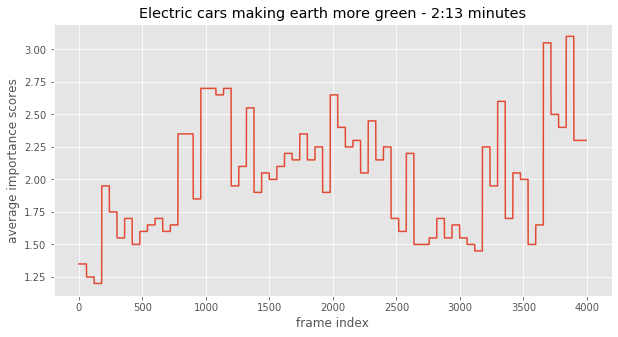

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(avg_scores_test))
ax.set_xlabel('frame index')
ax.set_ylabel('average importance scores')
ax.set_title('Electric cars making earth more green - 2:13 minutes')
ax.plot(x, avg_scores_test)

In [107]:
np.quantile(avg_scores_test, .90)

2.65

In [122]:
peaks, _ = find_peaks(avg_scores_test, height=np.quantile(avg_scores_test, .80))
peaks

array([ 839, 1019, 1168, 1348, 1768, 2008, 2307, 3326, 3686, 3866])

In [40]:
# 2 POTENTIAL APPROACHES

# 1. STATIC - clustering for static keyframe selection based on color histograms
# 2. DYNAMIC - create a model to take sequence of frames and predict the importance scores each frame 

In [40]:
def sort_frames(list_of_frames, video_id):
    return sorted(list_of_frames, key=lambda x: int(x.split(f'data/frames/train/{video_id}/')[1].split('.jpg')[0]))

In [37]:
# 3995 frames
ec_images = glob.glob('data/frames/train/akI8YFjEmUw/*')

In [41]:
ec_images = sort_frames(ec_images, 'akI8YFjEmUw')

In [44]:
ec_images

['data/frames/train/akI8YFjEmUw/0.jpg',
 'data/frames/train/akI8YFjEmUw/1.jpg',
 'data/frames/train/akI8YFjEmUw/2.jpg',
 'data/frames/train/akI8YFjEmUw/3.jpg',
 'data/frames/train/akI8YFjEmUw/4.jpg',
 'data/frames/train/akI8YFjEmUw/5.jpg',
 'data/frames/train/akI8YFjEmUw/6.jpg',
 'data/frames/train/akI8YFjEmUw/7.jpg',
 'data/frames/train/akI8YFjEmUw/8.jpg',
 'data/frames/train/akI8YFjEmUw/9.jpg',
 'data/frames/train/akI8YFjEmUw/10.jpg',
 'data/frames/train/akI8YFjEmUw/11.jpg',
 'data/frames/train/akI8YFjEmUw/12.jpg',
 'data/frames/train/akI8YFjEmUw/13.jpg',
 'data/frames/train/akI8YFjEmUw/14.jpg',
 'data/frames/train/akI8YFjEmUw/15.jpg',
 'data/frames/train/akI8YFjEmUw/16.jpg',
 'data/frames/train/akI8YFjEmUw/17.jpg',
 'data/frames/train/akI8YFjEmUw/18.jpg',
 'data/frames/train/akI8YFjEmUw/19.jpg',
 'data/frames/train/akI8YFjEmUw/20.jpg',
 'data/frames/train/akI8YFjEmUw/21.jpg',
 'data/frames/train/akI8YFjEmUw/22.jpg',
 'data/frames/train/akI8YFjEmUw/23.jpg',
 'data/frames/train/akI8YF

In [47]:
ec_image1 = plt.imread(glob.glob('data/frames/train/akI8YFjEmUw/*')[500])

In [48]:
ec_image1.shape

(360, 640, 3)

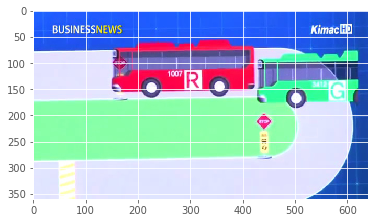

In [49]:
plt.imshow(ec_image1)

In [59]:
def get_image_features(frames_filepaths):
  image_features = []
  model = VGG16(weights='imagenet', include_top=False)
  for img_path in frames_filepaths:
      print(img_path)
      img = image.load_img(img_path, target_size=(224, 224))
      img_data = image.img_to_array(img)
      img_data = np.expand_dims(img_data, axis=0)
      img_data = preprocess_input(img_data)

      vgg16_feature = model.predict(img_data)
      image_features.append(np.array(vgg16_feature).flatten())
  return image_features

In [68]:
def kmeans(image_features, n_clusters):
  silhouette = np.zeros(n_clusters)
  for k in range(2, n_clusters):
    kmeans = KMeans(n_clusters=k).fit_predict(image_features)
    silhouette[k] = silhouette_score(image_features, kmeans)
    print(f'{k} cluster complete')
  return silhouette

In [ ]:
def random_frame_idxs_for_cluster(kmeans_labels):
  idxs = []
  for label in range(len(np.unique(kmeans_labels))):
    idxs.append(np.random.choice(np.argwhere(kmeans_labels == label).flatten(), 1)[0])
  return np.sort(np.array(idxs))

In [ ]:
def create_video_from_frames(frames, title, fps=30, fourcc=cv2.VideoWriter_fourcc('m','p','4','v')):
    img_array = []
    for filename in frames:
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(title, fourcc, 30, size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [74]:
def closest_to_centroid_frames(kmeans, image_list, image_features):
  closest, _ = pairwise_distances_argmin_min(
      kmeans.cluster_centers_, image_features)
  return np.array(image_list)[closest]

In [60]:
images_features = get_image_features(ec_images)

data/frames/train/akI8YFjEmUw/0.jpg
data/frames/train/akI8YFjEmUw/1.jpg
data/frames/train/akI8YFjEmUw/2.jpg
data/frames/train/akI8YFjEmUw/3.jpg
data/frames/train/akI8YFjEmUw/4.jpg
data/frames/train/akI8YFjEmUw/5.jpg
data/frames/train/akI8YFjEmUw/6.jpg
data/frames/train/akI8YFjEmUw/7.jpg
data/frames/train/akI8YFjEmUw/8.jpg
data/frames/train/akI8YFjEmUw/9.jpg
data/frames/train/akI8YFjEmUw/10.jpg
data/frames/train/akI8YFjEmUw/11.jpg
data/frames/train/akI8YFjEmUw/12.jpg
data/frames/train/akI8YFjEmUw/13.jpg
data/frames/train/akI8YFjEmUw/14.jpg
data/frames/train/akI8YFjEmUw/15.jpg
data/frames/train/akI8YFjEmUw/16.jpg
data/frames/train/akI8YFjEmUw/17.jpg
data/frames/train/akI8YFjEmUw/18.jpg
data/frames/train/akI8YFjEmUw/19.jpg
data/frames/train/akI8YFjEmUw/20.jpg
data/frames/train/akI8YFjEmUw/21.jpg
data/frames/train/akI8YFjEmUw/22.jpg
data/frames/train/akI8YFjEmUw/23.jpg
data/frames/train/akI8YFjEmUw/24.jpg
data/frames/train/akI8YFjEmUw/25.jpg
data/frames/train/akI8YFjEmUw/26.jpg
data/frames

data/frames/train/akI8YFjEmUw/219.jpg
data/frames/train/akI8YFjEmUw/220.jpg
data/frames/train/akI8YFjEmUw/221.jpg
data/frames/train/akI8YFjEmUw/222.jpg
data/frames/train/akI8YFjEmUw/223.jpg
data/frames/train/akI8YFjEmUw/224.jpg
data/frames/train/akI8YFjEmUw/225.jpg
data/frames/train/akI8YFjEmUw/226.jpg
data/frames/train/akI8YFjEmUw/227.jpg
data/frames/train/akI8YFjEmUw/228.jpg
data/frames/train/akI8YFjEmUw/229.jpg
data/frames/train/akI8YFjEmUw/230.jpg
data/frames/train/akI8YFjEmUw/231.jpg
data/frames/train/akI8YFjEmUw/232.jpg
data/frames/train/akI8YFjEmUw/233.jpg
data/frames/train/akI8YFjEmUw/234.jpg
data/frames/train/akI8YFjEmUw/235.jpg
data/frames/train/akI8YFjEmUw/236.jpg
data/frames/train/akI8YFjEmUw/237.jpg
data/frames/train/akI8YFjEmUw/238.jpg
data/frames/train/akI8YFjEmUw/239.jpg
data/frames/train/akI8YFjEmUw/240.jpg
data/frames/train/akI8YFjEmUw/241.jpg
data/frames/train/akI8YFjEmUw/242.jpg
data/frames/train/akI8YFjEmUw/243.jpg
data/frames/train/akI8YFjEmUw/244.jpg
data/frames/

data/frames/train/akI8YFjEmUw/435.jpg
data/frames/train/akI8YFjEmUw/436.jpg
data/frames/train/akI8YFjEmUw/437.jpg
data/frames/train/akI8YFjEmUw/438.jpg
data/frames/train/akI8YFjEmUw/439.jpg
data/frames/train/akI8YFjEmUw/440.jpg
data/frames/train/akI8YFjEmUw/441.jpg
data/frames/train/akI8YFjEmUw/442.jpg
data/frames/train/akI8YFjEmUw/443.jpg
data/frames/train/akI8YFjEmUw/444.jpg
data/frames/train/akI8YFjEmUw/445.jpg
data/frames/train/akI8YFjEmUw/446.jpg
data/frames/train/akI8YFjEmUw/447.jpg
data/frames/train/akI8YFjEmUw/448.jpg
data/frames/train/akI8YFjEmUw/449.jpg
data/frames/train/akI8YFjEmUw/450.jpg
data/frames/train/akI8YFjEmUw/451.jpg
data/frames/train/akI8YFjEmUw/452.jpg
data/frames/train/akI8YFjEmUw/453.jpg
data/frames/train/akI8YFjEmUw/454.jpg
data/frames/train/akI8YFjEmUw/455.jpg
data/frames/train/akI8YFjEmUw/456.jpg
data/frames/train/akI8YFjEmUw/457.jpg
data/frames/train/akI8YFjEmUw/458.jpg
data/frames/train/akI8YFjEmUw/459.jpg
data/frames/train/akI8YFjEmUw/460.jpg
data/frames/

data/frames/train/akI8YFjEmUw/651.jpg
data/frames/train/akI8YFjEmUw/652.jpg
data/frames/train/akI8YFjEmUw/653.jpg
data/frames/train/akI8YFjEmUw/654.jpg
data/frames/train/akI8YFjEmUw/655.jpg
data/frames/train/akI8YFjEmUw/656.jpg
data/frames/train/akI8YFjEmUw/657.jpg
data/frames/train/akI8YFjEmUw/658.jpg
data/frames/train/akI8YFjEmUw/659.jpg
data/frames/train/akI8YFjEmUw/660.jpg
data/frames/train/akI8YFjEmUw/661.jpg
data/frames/train/akI8YFjEmUw/662.jpg
data/frames/train/akI8YFjEmUw/663.jpg
data/frames/train/akI8YFjEmUw/664.jpg
data/frames/train/akI8YFjEmUw/665.jpg
data/frames/train/akI8YFjEmUw/666.jpg
data/frames/train/akI8YFjEmUw/667.jpg
data/frames/train/akI8YFjEmUw/668.jpg
data/frames/train/akI8YFjEmUw/669.jpg
data/frames/train/akI8YFjEmUw/670.jpg
data/frames/train/akI8YFjEmUw/671.jpg
data/frames/train/akI8YFjEmUw/672.jpg
data/frames/train/akI8YFjEmUw/673.jpg
data/frames/train/akI8YFjEmUw/674.jpg
data/frames/train/akI8YFjEmUw/675.jpg
data/frames/train/akI8YFjEmUw/676.jpg
data/frames/

data/frames/train/akI8YFjEmUw/867.jpg
data/frames/train/akI8YFjEmUw/868.jpg
data/frames/train/akI8YFjEmUw/869.jpg
data/frames/train/akI8YFjEmUw/870.jpg
data/frames/train/akI8YFjEmUw/871.jpg
data/frames/train/akI8YFjEmUw/872.jpg
data/frames/train/akI8YFjEmUw/873.jpg
data/frames/train/akI8YFjEmUw/874.jpg
data/frames/train/akI8YFjEmUw/875.jpg
data/frames/train/akI8YFjEmUw/876.jpg
data/frames/train/akI8YFjEmUw/877.jpg
data/frames/train/akI8YFjEmUw/878.jpg
data/frames/train/akI8YFjEmUw/879.jpg
data/frames/train/akI8YFjEmUw/880.jpg
data/frames/train/akI8YFjEmUw/881.jpg
data/frames/train/akI8YFjEmUw/882.jpg
data/frames/train/akI8YFjEmUw/883.jpg
data/frames/train/akI8YFjEmUw/884.jpg
data/frames/train/akI8YFjEmUw/885.jpg
data/frames/train/akI8YFjEmUw/886.jpg
data/frames/train/akI8YFjEmUw/887.jpg
data/frames/train/akI8YFjEmUw/888.jpg
data/frames/train/akI8YFjEmUw/889.jpg
data/frames/train/akI8YFjEmUw/890.jpg
data/frames/train/akI8YFjEmUw/891.jpg
data/frames/train/akI8YFjEmUw/892.jpg
data/frames/

data/frames/train/akI8YFjEmUw/1081.jpg
data/frames/train/akI8YFjEmUw/1082.jpg
data/frames/train/akI8YFjEmUw/1083.jpg
data/frames/train/akI8YFjEmUw/1084.jpg
data/frames/train/akI8YFjEmUw/1085.jpg
data/frames/train/akI8YFjEmUw/1086.jpg
data/frames/train/akI8YFjEmUw/1087.jpg
data/frames/train/akI8YFjEmUw/1088.jpg
data/frames/train/akI8YFjEmUw/1089.jpg
data/frames/train/akI8YFjEmUw/1090.jpg
data/frames/train/akI8YFjEmUw/1091.jpg
data/frames/train/akI8YFjEmUw/1092.jpg
data/frames/train/akI8YFjEmUw/1093.jpg
data/frames/train/akI8YFjEmUw/1094.jpg
data/frames/train/akI8YFjEmUw/1095.jpg
data/frames/train/akI8YFjEmUw/1096.jpg
data/frames/train/akI8YFjEmUw/1097.jpg
data/frames/train/akI8YFjEmUw/1098.jpg
data/frames/train/akI8YFjEmUw/1099.jpg
data/frames/train/akI8YFjEmUw/1100.jpg
data/frames/train/akI8YFjEmUw/1101.jpg
data/frames/train/akI8YFjEmUw/1102.jpg
data/frames/train/akI8YFjEmUw/1103.jpg
data/frames/train/akI8YFjEmUw/1104.jpg
data/frames/train/akI8YFjEmUw/1105.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/1292.jpg
data/frames/train/akI8YFjEmUw/1293.jpg
data/frames/train/akI8YFjEmUw/1294.jpg
data/frames/train/akI8YFjEmUw/1295.jpg
data/frames/train/akI8YFjEmUw/1296.jpg
data/frames/train/akI8YFjEmUw/1297.jpg
data/frames/train/akI8YFjEmUw/1298.jpg
data/frames/train/akI8YFjEmUw/1299.jpg
data/frames/train/akI8YFjEmUw/1300.jpg
data/frames/train/akI8YFjEmUw/1301.jpg
data/frames/train/akI8YFjEmUw/1302.jpg
data/frames/train/akI8YFjEmUw/1303.jpg
data/frames/train/akI8YFjEmUw/1304.jpg
data/frames/train/akI8YFjEmUw/1305.jpg
data/frames/train/akI8YFjEmUw/1306.jpg
data/frames/train/akI8YFjEmUw/1307.jpg
data/frames/train/akI8YFjEmUw/1308.jpg
data/frames/train/akI8YFjEmUw/1309.jpg
data/frames/train/akI8YFjEmUw/1310.jpg
data/frames/train/akI8YFjEmUw/1311.jpg
data/frames/train/akI8YFjEmUw/1312.jpg
data/frames/train/akI8YFjEmUw/1313.jpg
data/frames/train/akI8YFjEmUw/1314.jpg
data/frames/train/akI8YFjEmUw/1315.jpg
data/frames/train/akI8YFjEmUw/1316.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/1503.jpg
data/frames/train/akI8YFjEmUw/1504.jpg
data/frames/train/akI8YFjEmUw/1505.jpg
data/frames/train/akI8YFjEmUw/1506.jpg
data/frames/train/akI8YFjEmUw/1507.jpg
data/frames/train/akI8YFjEmUw/1508.jpg
data/frames/train/akI8YFjEmUw/1509.jpg
data/frames/train/akI8YFjEmUw/1510.jpg
data/frames/train/akI8YFjEmUw/1511.jpg
data/frames/train/akI8YFjEmUw/1512.jpg
data/frames/train/akI8YFjEmUw/1513.jpg
data/frames/train/akI8YFjEmUw/1514.jpg
data/frames/train/akI8YFjEmUw/1515.jpg
data/frames/train/akI8YFjEmUw/1516.jpg
data/frames/train/akI8YFjEmUw/1517.jpg
data/frames/train/akI8YFjEmUw/1518.jpg
data/frames/train/akI8YFjEmUw/1519.jpg
data/frames/train/akI8YFjEmUw/1520.jpg
data/frames/train/akI8YFjEmUw/1521.jpg
data/frames/train/akI8YFjEmUw/1522.jpg
data/frames/train/akI8YFjEmUw/1523.jpg
data/frames/train/akI8YFjEmUw/1524.jpg
data/frames/train/akI8YFjEmUw/1525.jpg
data/frames/train/akI8YFjEmUw/1526.jpg
data/frames/train/akI8YFjEmUw/1527.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/1714.jpg
data/frames/train/akI8YFjEmUw/1715.jpg
data/frames/train/akI8YFjEmUw/1716.jpg
data/frames/train/akI8YFjEmUw/1717.jpg
data/frames/train/akI8YFjEmUw/1718.jpg
data/frames/train/akI8YFjEmUw/1719.jpg
data/frames/train/akI8YFjEmUw/1720.jpg
data/frames/train/akI8YFjEmUw/1721.jpg
data/frames/train/akI8YFjEmUw/1722.jpg
data/frames/train/akI8YFjEmUw/1723.jpg
data/frames/train/akI8YFjEmUw/1724.jpg
data/frames/train/akI8YFjEmUw/1725.jpg
data/frames/train/akI8YFjEmUw/1726.jpg
data/frames/train/akI8YFjEmUw/1727.jpg
data/frames/train/akI8YFjEmUw/1728.jpg
data/frames/train/akI8YFjEmUw/1729.jpg
data/frames/train/akI8YFjEmUw/1730.jpg
data/frames/train/akI8YFjEmUw/1731.jpg
data/frames/train/akI8YFjEmUw/1732.jpg
data/frames/train/akI8YFjEmUw/1733.jpg
data/frames/train/akI8YFjEmUw/1734.jpg
data/frames/train/akI8YFjEmUw/1735.jpg
data/frames/train/akI8YFjEmUw/1736.jpg
data/frames/train/akI8YFjEmUw/1737.jpg
data/frames/train/akI8YFjEmUw/1738.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/1925.jpg
data/frames/train/akI8YFjEmUw/1926.jpg
data/frames/train/akI8YFjEmUw/1927.jpg
data/frames/train/akI8YFjEmUw/1928.jpg
data/frames/train/akI8YFjEmUw/1929.jpg
data/frames/train/akI8YFjEmUw/1930.jpg
data/frames/train/akI8YFjEmUw/1931.jpg
data/frames/train/akI8YFjEmUw/1932.jpg
data/frames/train/akI8YFjEmUw/1933.jpg
data/frames/train/akI8YFjEmUw/1934.jpg
data/frames/train/akI8YFjEmUw/1935.jpg
data/frames/train/akI8YFjEmUw/1936.jpg
data/frames/train/akI8YFjEmUw/1937.jpg
data/frames/train/akI8YFjEmUw/1938.jpg
data/frames/train/akI8YFjEmUw/1939.jpg
data/frames/train/akI8YFjEmUw/1940.jpg
data/frames/train/akI8YFjEmUw/1941.jpg
data/frames/train/akI8YFjEmUw/1942.jpg
data/frames/train/akI8YFjEmUw/1943.jpg
data/frames/train/akI8YFjEmUw/1944.jpg
data/frames/train/akI8YFjEmUw/1945.jpg
data/frames/train/akI8YFjEmUw/1946.jpg
data/frames/train/akI8YFjEmUw/1947.jpg
data/frames/train/akI8YFjEmUw/1948.jpg
data/frames/train/akI8YFjEmUw/1949.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/2136.jpg
data/frames/train/akI8YFjEmUw/2137.jpg
data/frames/train/akI8YFjEmUw/2138.jpg
data/frames/train/akI8YFjEmUw/2139.jpg
data/frames/train/akI8YFjEmUw/2140.jpg
data/frames/train/akI8YFjEmUw/2141.jpg
data/frames/train/akI8YFjEmUw/2142.jpg
data/frames/train/akI8YFjEmUw/2143.jpg
data/frames/train/akI8YFjEmUw/2144.jpg
data/frames/train/akI8YFjEmUw/2145.jpg
data/frames/train/akI8YFjEmUw/2146.jpg
data/frames/train/akI8YFjEmUw/2147.jpg
data/frames/train/akI8YFjEmUw/2148.jpg
data/frames/train/akI8YFjEmUw/2149.jpg
data/frames/train/akI8YFjEmUw/2150.jpg
data/frames/train/akI8YFjEmUw/2151.jpg
data/frames/train/akI8YFjEmUw/2152.jpg
data/frames/train/akI8YFjEmUw/2153.jpg
data/frames/train/akI8YFjEmUw/2154.jpg
data/frames/train/akI8YFjEmUw/2155.jpg
data/frames/train/akI8YFjEmUw/2156.jpg
data/frames/train/akI8YFjEmUw/2157.jpg
data/frames/train/akI8YFjEmUw/2158.jpg
data/frames/train/akI8YFjEmUw/2159.jpg
data/frames/train/akI8YFjEmUw/2160.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/2347.jpg
data/frames/train/akI8YFjEmUw/2348.jpg
data/frames/train/akI8YFjEmUw/2349.jpg
data/frames/train/akI8YFjEmUw/2350.jpg
data/frames/train/akI8YFjEmUw/2351.jpg
data/frames/train/akI8YFjEmUw/2352.jpg
data/frames/train/akI8YFjEmUw/2353.jpg
data/frames/train/akI8YFjEmUw/2354.jpg
data/frames/train/akI8YFjEmUw/2355.jpg
data/frames/train/akI8YFjEmUw/2356.jpg
data/frames/train/akI8YFjEmUw/2357.jpg
data/frames/train/akI8YFjEmUw/2358.jpg
data/frames/train/akI8YFjEmUw/2359.jpg
data/frames/train/akI8YFjEmUw/2360.jpg
data/frames/train/akI8YFjEmUw/2361.jpg
data/frames/train/akI8YFjEmUw/2362.jpg
data/frames/train/akI8YFjEmUw/2363.jpg
data/frames/train/akI8YFjEmUw/2364.jpg
data/frames/train/akI8YFjEmUw/2365.jpg
data/frames/train/akI8YFjEmUw/2366.jpg
data/frames/train/akI8YFjEmUw/2367.jpg
data/frames/train/akI8YFjEmUw/2368.jpg
data/frames/train/akI8YFjEmUw/2369.jpg
data/frames/train/akI8YFjEmUw/2370.jpg
data/frames/train/akI8YFjEmUw/2371.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/2558.jpg
data/frames/train/akI8YFjEmUw/2559.jpg
data/frames/train/akI8YFjEmUw/2560.jpg
data/frames/train/akI8YFjEmUw/2561.jpg
data/frames/train/akI8YFjEmUw/2562.jpg
data/frames/train/akI8YFjEmUw/2563.jpg
data/frames/train/akI8YFjEmUw/2564.jpg
data/frames/train/akI8YFjEmUw/2565.jpg
data/frames/train/akI8YFjEmUw/2566.jpg
data/frames/train/akI8YFjEmUw/2567.jpg
data/frames/train/akI8YFjEmUw/2568.jpg
data/frames/train/akI8YFjEmUw/2569.jpg
data/frames/train/akI8YFjEmUw/2570.jpg
data/frames/train/akI8YFjEmUw/2571.jpg
data/frames/train/akI8YFjEmUw/2572.jpg
data/frames/train/akI8YFjEmUw/2573.jpg
data/frames/train/akI8YFjEmUw/2574.jpg
data/frames/train/akI8YFjEmUw/2575.jpg
data/frames/train/akI8YFjEmUw/2576.jpg
data/frames/train/akI8YFjEmUw/2577.jpg
data/frames/train/akI8YFjEmUw/2578.jpg
data/frames/train/akI8YFjEmUw/2579.jpg
data/frames/train/akI8YFjEmUw/2580.jpg
data/frames/train/akI8YFjEmUw/2581.jpg
data/frames/train/akI8YFjEmUw/2582.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/2770.jpg
data/frames/train/akI8YFjEmUw/2771.jpg
data/frames/train/akI8YFjEmUw/2772.jpg
data/frames/train/akI8YFjEmUw/2773.jpg
data/frames/train/akI8YFjEmUw/2774.jpg
data/frames/train/akI8YFjEmUw/2775.jpg
data/frames/train/akI8YFjEmUw/2776.jpg
data/frames/train/akI8YFjEmUw/2777.jpg
data/frames/train/akI8YFjEmUw/2778.jpg
data/frames/train/akI8YFjEmUw/2779.jpg
data/frames/train/akI8YFjEmUw/2780.jpg
data/frames/train/akI8YFjEmUw/2781.jpg
data/frames/train/akI8YFjEmUw/2782.jpg
data/frames/train/akI8YFjEmUw/2783.jpg
data/frames/train/akI8YFjEmUw/2784.jpg
data/frames/train/akI8YFjEmUw/2785.jpg
data/frames/train/akI8YFjEmUw/2786.jpg
data/frames/train/akI8YFjEmUw/2787.jpg
data/frames/train/akI8YFjEmUw/2788.jpg
data/frames/train/akI8YFjEmUw/2789.jpg
data/frames/train/akI8YFjEmUw/2790.jpg
data/frames/train/akI8YFjEmUw/2791.jpg
data/frames/train/akI8YFjEmUw/2792.jpg
data/frames/train/akI8YFjEmUw/2793.jpg
data/frames/train/akI8YFjEmUw/2794.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/2981.jpg
data/frames/train/akI8YFjEmUw/2982.jpg
data/frames/train/akI8YFjEmUw/2983.jpg
data/frames/train/akI8YFjEmUw/2984.jpg
data/frames/train/akI8YFjEmUw/2985.jpg
data/frames/train/akI8YFjEmUw/2986.jpg
data/frames/train/akI8YFjEmUw/2987.jpg
data/frames/train/akI8YFjEmUw/2988.jpg
data/frames/train/akI8YFjEmUw/2989.jpg
data/frames/train/akI8YFjEmUw/2990.jpg
data/frames/train/akI8YFjEmUw/2991.jpg
data/frames/train/akI8YFjEmUw/2992.jpg
data/frames/train/akI8YFjEmUw/2993.jpg
data/frames/train/akI8YFjEmUw/2994.jpg
data/frames/train/akI8YFjEmUw/2995.jpg
data/frames/train/akI8YFjEmUw/2996.jpg
data/frames/train/akI8YFjEmUw/2997.jpg
data/frames/train/akI8YFjEmUw/2998.jpg
data/frames/train/akI8YFjEmUw/2999.jpg
data/frames/train/akI8YFjEmUw/3000.jpg
data/frames/train/akI8YFjEmUw/3001.jpg
data/frames/train/akI8YFjEmUw/3002.jpg
data/frames/train/akI8YFjEmUw/3003.jpg
data/frames/train/akI8YFjEmUw/3004.jpg
data/frames/train/akI8YFjEmUw/3005.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/3192.jpg
data/frames/train/akI8YFjEmUw/3193.jpg
data/frames/train/akI8YFjEmUw/3194.jpg
data/frames/train/akI8YFjEmUw/3195.jpg
data/frames/train/akI8YFjEmUw/3196.jpg
data/frames/train/akI8YFjEmUw/3197.jpg
data/frames/train/akI8YFjEmUw/3198.jpg
data/frames/train/akI8YFjEmUw/3199.jpg
data/frames/train/akI8YFjEmUw/3200.jpg
data/frames/train/akI8YFjEmUw/3201.jpg
data/frames/train/akI8YFjEmUw/3202.jpg
data/frames/train/akI8YFjEmUw/3203.jpg
data/frames/train/akI8YFjEmUw/3204.jpg
data/frames/train/akI8YFjEmUw/3205.jpg
data/frames/train/akI8YFjEmUw/3206.jpg
data/frames/train/akI8YFjEmUw/3207.jpg
data/frames/train/akI8YFjEmUw/3208.jpg
data/frames/train/akI8YFjEmUw/3209.jpg
data/frames/train/akI8YFjEmUw/3210.jpg
data/frames/train/akI8YFjEmUw/3211.jpg
data/frames/train/akI8YFjEmUw/3212.jpg
data/frames/train/akI8YFjEmUw/3213.jpg
data/frames/train/akI8YFjEmUw/3214.jpg
data/frames/train/akI8YFjEmUw/3215.jpg
data/frames/train/akI8YFjEmUw/3216.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/3403.jpg
data/frames/train/akI8YFjEmUw/3404.jpg
data/frames/train/akI8YFjEmUw/3405.jpg
data/frames/train/akI8YFjEmUw/3406.jpg
data/frames/train/akI8YFjEmUw/3407.jpg
data/frames/train/akI8YFjEmUw/3408.jpg
data/frames/train/akI8YFjEmUw/3409.jpg
data/frames/train/akI8YFjEmUw/3410.jpg
data/frames/train/akI8YFjEmUw/3411.jpg
data/frames/train/akI8YFjEmUw/3412.jpg
data/frames/train/akI8YFjEmUw/3413.jpg
data/frames/train/akI8YFjEmUw/3414.jpg
data/frames/train/akI8YFjEmUw/3415.jpg
data/frames/train/akI8YFjEmUw/3416.jpg
data/frames/train/akI8YFjEmUw/3417.jpg
data/frames/train/akI8YFjEmUw/3418.jpg
data/frames/train/akI8YFjEmUw/3419.jpg
data/frames/train/akI8YFjEmUw/3420.jpg
data/frames/train/akI8YFjEmUw/3421.jpg
data/frames/train/akI8YFjEmUw/3422.jpg
data/frames/train/akI8YFjEmUw/3423.jpg
data/frames/train/akI8YFjEmUw/3424.jpg
data/frames/train/akI8YFjEmUw/3425.jpg
data/frames/train/akI8YFjEmUw/3426.jpg
data/frames/train/akI8YFjEmUw/3427.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/3614.jpg
data/frames/train/akI8YFjEmUw/3615.jpg
data/frames/train/akI8YFjEmUw/3616.jpg
data/frames/train/akI8YFjEmUw/3617.jpg
data/frames/train/akI8YFjEmUw/3618.jpg
data/frames/train/akI8YFjEmUw/3619.jpg
data/frames/train/akI8YFjEmUw/3620.jpg
data/frames/train/akI8YFjEmUw/3621.jpg
data/frames/train/akI8YFjEmUw/3622.jpg
data/frames/train/akI8YFjEmUw/3623.jpg
data/frames/train/akI8YFjEmUw/3624.jpg
data/frames/train/akI8YFjEmUw/3625.jpg
data/frames/train/akI8YFjEmUw/3626.jpg
data/frames/train/akI8YFjEmUw/3627.jpg
data/frames/train/akI8YFjEmUw/3628.jpg
data/frames/train/akI8YFjEmUw/3629.jpg
data/frames/train/akI8YFjEmUw/3630.jpg
data/frames/train/akI8YFjEmUw/3631.jpg
data/frames/train/akI8YFjEmUw/3632.jpg
data/frames/train/akI8YFjEmUw/3633.jpg
data/frames/train/akI8YFjEmUw/3634.jpg
data/frames/train/akI8YFjEmUw/3635.jpg
data/frames/train/akI8YFjEmUw/3636.jpg
data/frames/train/akI8YFjEmUw/3637.jpg
data/frames/train/akI8YFjEmUw/3638.jpg
data/frames/train/akI8YFj

data/frames/train/akI8YFjEmUw/3825.jpg
data/frames/train/akI8YFjEmUw/3826.jpg
data/frames/train/akI8YFjEmUw/3827.jpg
data/frames/train/akI8YFjEmUw/3828.jpg
data/frames/train/akI8YFjEmUw/3829.jpg
data/frames/train/akI8YFjEmUw/3830.jpg
data/frames/train/akI8YFjEmUw/3831.jpg
data/frames/train/akI8YFjEmUw/3832.jpg
data/frames/train/akI8YFjEmUw/3833.jpg
data/frames/train/akI8YFjEmUw/3834.jpg
data/frames/train/akI8YFjEmUw/3835.jpg
data/frames/train/akI8YFjEmUw/3836.jpg
data/frames/train/akI8YFjEmUw/3837.jpg
data/frames/train/akI8YFjEmUw/3838.jpg
data/frames/train/akI8YFjEmUw/3839.jpg
data/frames/train/akI8YFjEmUw/3840.jpg
data/frames/train/akI8YFjEmUw/3841.jpg
data/frames/train/akI8YFjEmUw/3842.jpg
data/frames/train/akI8YFjEmUw/3843.jpg
data/frames/train/akI8YFjEmUw/3844.jpg
data/frames/train/akI8YFjEmUw/3845.jpg
data/frames/train/akI8YFjEmUw/3846.jpg
data/frames/train/akI8YFjEmUw/3847.jpg
data/frames/train/akI8YFjEmUw/3848.jpg
data/frames/train/akI8YFjEmUw/3849.jpg
data/frames/train/akI8YFj

In [63]:
kmeans5 = KMeans(n_clusters=5, random_state=42).fit(images_features)

In [123]:
kmeans10 = KMeans(n_clusters=10, random_state=42).fit(images_features)

In [75]:
five_frames = closest_to_centroid_frames(kmeans5, ec_images, images_features)

In [124]:
ten_frames = closest_to_centroid_frames(kmeans10, ec_images, images_features)

In [79]:
sorted_five_frames = sort_frames(five_frames, 'akI8YFjEmUw')
sorted_five_frames

['data/frames/train/akI8YFjEmUw/110.jpg',
 'data/frames/train/akI8YFjEmUw/474.jpg',
 'data/frames/train/akI8YFjEmUw/1747.jpg',
 'data/frames/train/akI8YFjEmUw/2895.jpg',
 'data/frames/train/akI8YFjEmUw/3873.jpg']

In [125]:
sorted_ten_frames = sort_frames(ten_frames, 'akI8YFjEmUw')
sorted_ten_frames

['data/frames/train/akI8YFjEmUw/110.jpg',
 'data/frames/train/akI8YFjEmUw/474.jpg',
 'data/frames/train/akI8YFjEmUw/1086.jpg',
 'data/frames/train/akI8YFjEmUw/1747.jpg',
 'data/frames/train/akI8YFjEmUw/1974.jpg',
 'data/frames/train/akI8YFjEmUw/2073.jpg',
 'data/frames/train/akI8YFjEmUw/2438.jpg',
 'data/frames/train/akI8YFjEmUw/2895.jpg',
 'data/frames/train/akI8YFjEmUw/3425.jpg',
 'data/frames/train/akI8YFjEmUw/3873.jpg']

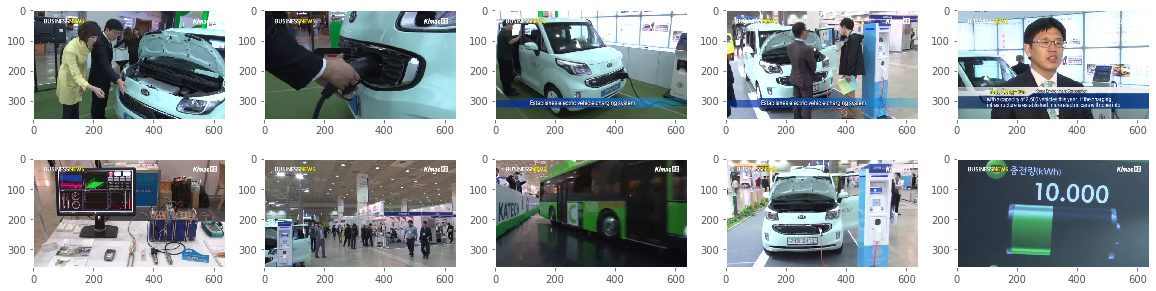

In [141]:
peaks, _ = find_peaks(avg_scores_test, height=np.quantile(avg_scores_test, .80))
peak_frames = np.array(ec_images)[peaks]
fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for frame, ax in zip(peak_frames, axs.flatten()):
     ax.imshow(plt.imread(frame))

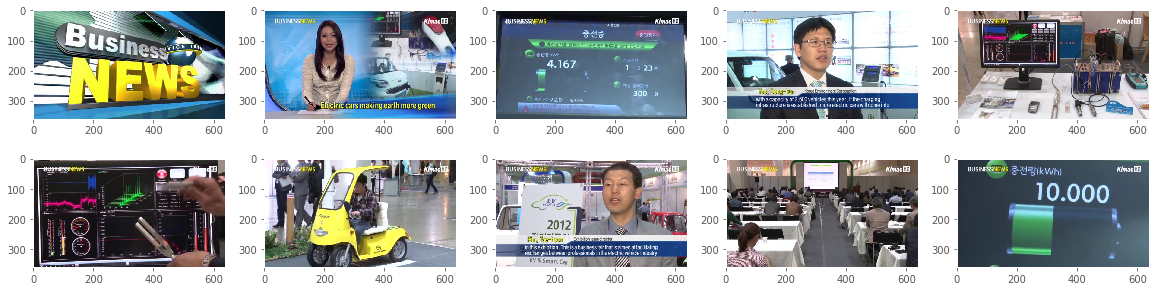

In [142]:
# CLUSTERED 10

fig, axs = plt.subplots(2, 5, figsize=(20, 5))
for frame, ax in zip(sorted_ten_frames, axs.flatten()):
     ax.imshow(plt.imread(frame))
     plt.grid(None)

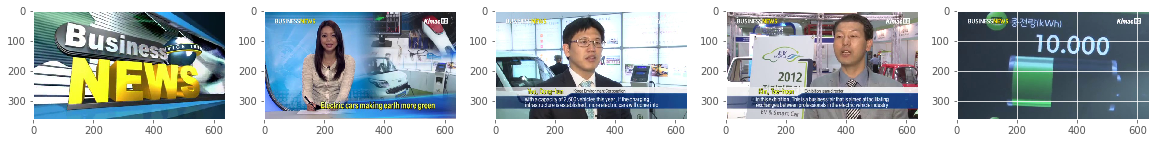

In [134]:
# CLUSTERED 5

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for frame, ax in zip(sorted_five_frames, axs.flatten()):
     ax.imshow(plt.imread(frame))
     plt.grid(None) 

In [353]:
## EXPERIMENTAL APPROACH BELOW -----
# Using Kmeans for with 400 clusters to experiment with a creating a video that is 10% of original 
kmeans = KMeans(n_clusters=400, random_state=42).fit(image_features)

In [359]:
kmeans.cluster_centers_.shape

(400, 25088)

In [384]:
kmeans.labels_

array([155, 139, 323, ..., 235, 269, 339], dtype=int32)

In [ ]:
# labels = kmeans.labels_
# np.argwhere(labels == 315)

In [397]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, image_features)

In [402]:
closest

array([1040, 1407,  773,  112, 3261, 2097, 2860, 3160, 3592, 2929, 3893,
       1239, 2506, 3917,  566,  142, 3482, 1851, 2075,  560, 3818, 3896,
       2303, 2795,  934, 2654, 3796, 3325, 3988, 3136, 1642,  451, 1229,
        709, 1243, 2060, 3196, 2583, 3876, 1761,  260, 2044,  272, 2995,
       2858, 2714, 3502,  643, 3860,  368, 3755,  277,  978, 3344, 3779,
       3444, 3384, 2554, 2190, 3507,  710, 3498, 3770,  367,  379, 3176,
       1256, 1905, 2680, 3405,  326, 1353, 2527, 2898,  997, 2962,  235,
       1717,  308,  564, 1907, 2495, 3681, 3691, 1460, 1313,  498,  399,
        360, 1962, 2660, 3242,  187, 2021,  863, 2163, 1334, 2123, 2741,
       2513, 1285, 3966,  306,   41, 3289, 1450, 2502, 1588, 2740, 3519,
       3426, 3672, 1551, 2735,  204, 1319, 3434, 3827, 3281, 3045, 2369,
        678, 2505, 2194,  403, 3656, 1961, 3100, 2994,  445, 2397, 2247,
       1351,  417, 2781, 3012,  229, 3797,  829,  250, 3334, 1772,  469,
       2148, 2992, 1822, 2120, 2461,  520, 1427, 33

In [425]:
ec_images_np[closest]

array(['data/frames/akI8YFjEmUw/3719.jpg',
       'data/frames/akI8YFjEmUw/3848.jpg',
       'data/frames/akI8YFjEmUw/601.jpg',
       'data/frames/akI8YFjEmUw/1555.jpg',
       'data/frames/akI8YFjEmUw/2687.jpg',
       'data/frames/akI8YFjEmUw/3472.jpg',
       'data/frames/akI8YFjEmUw/2026.jpg',
       'data/frames/akI8YFjEmUw/1987.jpg',
       'data/frames/akI8YFjEmUw/3371.jpg',
       'data/frames/akI8YFjEmUw/2422.jpg',
       'data/frames/akI8YFjEmUw/796.jpg',
       'data/frames/akI8YFjEmUw/1331.jpg',
       'data/frames/akI8YFjEmUw/126.jpg',
       'data/frames/akI8YFjEmUw/3165.jpg',
       'data/frames/akI8YFjEmUw/3620.jpg',
       'data/frames/akI8YFjEmUw/1232.jpg',
       'data/frames/akI8YFjEmUw/2137.jpg',
       'data/frames/akI8YFjEmUw/919.jpg',
       'data/frames/akI8YFjEmUw/2591.jpg',
       'data/frames/akI8YFjEmUw/1194.jpg',
       'data/frames/akI8YFjEmUw/2246.jpg',
       'data/frames/akI8YFjEmUw/2284.jpg',
       'data/frames/akI8YFjEmUw/2551.jpg',
       'data/fr

In [437]:
closest_to_center_frames = sort_frames(ec_images_np[closest], 'akI8YFjEmUw')
closest_to_center_frames

['data/frames/akI8YFjEmUw/1.jpg',
 'data/frames/akI8YFjEmUw/3.jpg',
 'data/frames/akI8YFjEmUw/6.jpg',
 'data/frames/akI8YFjEmUw/7.jpg',
 'data/frames/akI8YFjEmUw/8.jpg',
 'data/frames/akI8YFjEmUw/9.jpg',
 'data/frames/akI8YFjEmUw/11.jpg',
 'data/frames/akI8YFjEmUw/13.jpg',
 'data/frames/akI8YFjEmUw/14.jpg',
 'data/frames/akI8YFjEmUw/15.jpg',
 'data/frames/akI8YFjEmUw/16.jpg',
 'data/frames/akI8YFjEmUw/17.jpg',
 'data/frames/akI8YFjEmUw/18.jpg',
 'data/frames/akI8YFjEmUw/21.jpg',
 'data/frames/akI8YFjEmUw/23.jpg',
 'data/frames/akI8YFjEmUw/26.jpg',
 'data/frames/akI8YFjEmUw/28.jpg',
 'data/frames/akI8YFjEmUw/30.jpg',
 'data/frames/akI8YFjEmUw/33.jpg',
 'data/frames/akI8YFjEmUw/35.jpg',
 'data/frames/akI8YFjEmUw/38.jpg',
 'data/frames/akI8YFjEmUw/41.jpg',
 'data/frames/akI8YFjEmUw/46.jpg',
 'data/frames/akI8YFjEmUw/50.jpg',
 'data/frames/akI8YFjEmUw/54.jpg',
 'data/frames/akI8YFjEmUw/57.jpg',
 'data/frames/akI8YFjEmUw/61.jpg',
 'data/frames/akI8YFjEmUw/65.jpg',
 'data/frames/akI8YFjEmUw/

In [436]:
# REMEMBER TO SORT LIST OF FRAMES after glob
# sort_frames(glob.glob('data/frames/akI8YFjEmUw/*'), 'akI8YFjEmUw')

In [444]:
# 3995 
# 133 seconds
3995 / 133

30.037593984962406

In [455]:
original_frames = sort_frames(glob.glob('data/frames/akI8YFjEmUw/*'), 'akI8YFjEmUw')
create_video_from_frames(original_frames, 'test-original.mp4')

In [456]:
create_video_from_frames(closest_to_center_frames, 'test-condensed.mp4')

In [127]:
# rgb histogram approach for clustering 

sorted_image_list = sort_frames(ec_images_np, 'akI8YFjEmUw')

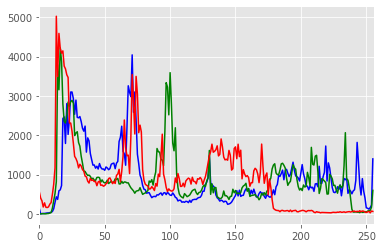

In [133]:
# Example RGB histogram 

img = cv2.imread(random_frames[100])
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

In [ ]:
# img = cv2.imread(sorted_image_list[0])
# hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
# (hist.shape, hist.flatten().shape[0])

In [10]:
# y = []
# for frame in random_frames:
#     img = cv2.imread(frame)
#     histr = cv2.calcHist([img],[i],None,[256],[0,256])
#     y.append(histr)

def rgb_to_hsv_histogram_features(image_list, bins):
    features = []
    for frame in image_list:
      cv_img = cv2.imread(frame)
      img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2HSV)
      histr = cv2.calcHist([cv_img], [0, 1, 2], None, [
                           bins, bins, bins], [0, 256, 0, 256, 0, 256])
      cv2.normalize(hist, hist)
      features.append(histr.flatten())
    return features

In [ ]:
# y = rgb_to_hsv_histogram_features(sorted_image_list)
# y.shape

In [173]:
kmeans_rgb = KMeans(n_clusters=13).fit(y)

In [174]:
kmeans_rgb.labels_

array([12, 12, 12, ...,  6,  6,  6], dtype=int32)

In [175]:
kmeans_rgb.cluster_centers_

array([[ 5.30435181e+01,  4.34306564e+01,  6.00165482e+01, ...,
         1.36142761e+02,  2.15817261e+02,  9.31232422e+02],
       [ 3.50842590e+01,  9.51403809e+00,  1.06830368e+01, ...,
         1.93872107e+03,  4.49775146e+03,  1.48950029e+04],
       [ 2.24262543e+02,  1.30407715e+02,  1.44970978e+02, ...,
         6.25124512e+01,  1.07583496e+02,  4.34215820e+02],
       ...,
       [ 3.01107788e+00,  1.83899689e+00,  4.16090393e+00, ...,
         6.91154785e+01,  1.99864136e+02,  2.97555664e+02],
       [-4.27246094e-04, -7.62939453e-05, -2.28881836e-05, ...,
         1.25238037e+01,  2.62115479e+01,  2.43295898e+01],
       [ 2.91174951e+03,  8.53042847e+02,  7.77896362e+02, ...,
         8.53527539e+03,  8.55629492e+03,  1.34783320e+04]], dtype=float32)

In [176]:
random_frame_idxs_for_cluster(kmeans_rgb.labels_)

array([  39, 1040, 1279, 1495, 2158, 2256, 2730, 3168, 3234, 3493, 3627,
       3841, 3946])

In [177]:
rfi = random_frame_idxs_for_cluster(kmeans_rgb.labels_)

In [180]:
# random_frames = np.array(random_frames)
sorted_image_list = np.array(sorted_image_list)

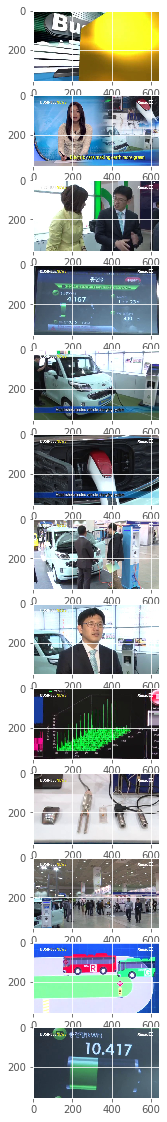

In [183]:
rgb_13_frames = sort_frames(sorted_image_list[rfi], 'akI8YFjEmUw')

fig, axs = plt.subplots(13, 1, figsize=(20, 20))
for frame, ax in zip(rgb_13_frames, axs.flatten()):
     ax.imshow(plt.imread(frame))